In [34]:
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import math


In [35]:
univ = ['QQQ', 'TLT', 'GLD', 'RWO']
px = yf.download(univ, start="2016-01-01")['Close']
ret = px.pct_change().dropna()


/var/folders/sd/gwy5_jls1nzcg7ym17mcfgn00000gn/T/ipykernel_64305/2021929620.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(univ, start="2016-01-01")['Close']
[*********************100%***********************]  4 of 4 completed


In [36]:
def compute_momentum(ret):
    return ret.rolling(252).mean() / ret.rolling(252).std() * math.sqrt(252)

momentum = compute_momentum(ret)


In [37]:
def compute_portfolio(momentum):
    portfolio = (momentum > 1).astype(float)
    portfolio = portfolio.div(portfolio.abs().sum(axis=1), axis=0)
    return portfolio

portfolio = compute_portfolio(momentum)


Annualized Sharpe Ratio: 1.2312355494156058
Yearly Sharpe Ratios:
 Date
2017    2.670442
2018   -0.024997
2019    1.015491
2020    1.528309
2021    1.411047
2022   -0.737297
2023    1.171872
2024    1.802068
2025    2.607691
dtype: float64
Correlation with underlying tickers:
 Ticker
GLD    0.428065
QQQ    0.414819
RWO    0.242333
TLT    0.190534
dtype: float64


<Axes: xlabel='Date'>

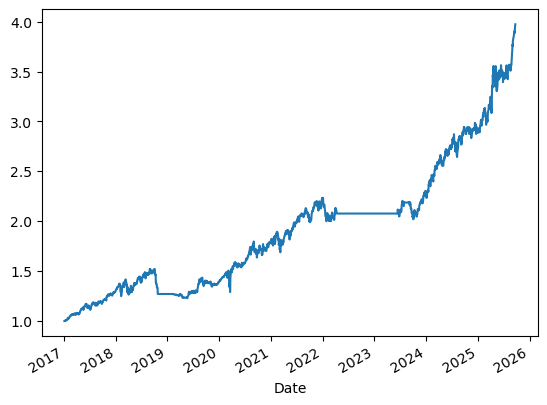

In [38]:
strat_ret = (portfolio.shift() * ret).sum(axis=1)
strat_ret = strat_ret.loc[momentum.dropna().index[0]:]


sharpe_annual = strat_ret.mean() / strat_ret.std() * math.sqrt(252)
print("Annualized Sharpe Ratio:", sharpe_annual)


sharpe_yearly = strat_ret.groupby(strat_ret.index.year).apply(
    lambda x: x.mean() / x.std() * math.sqrt(252)
)
print("Yearly Sharpe Ratios:\n", sharpe_yearly)


corr = ret.corrwith(strat_ret)
print("Correlation with underlying tickers:\n", corr)


(1 + strat_ret).cumprod().plot()

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

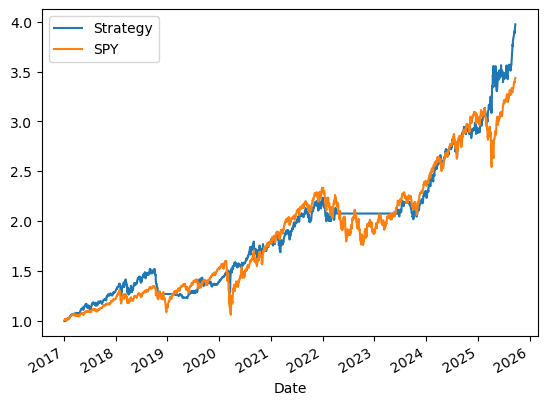

In [ ]:
spy = yf.download('SPY', start="2016-01-01")['Close']
spy_ret = spy.pct_change().dropna()


data = pd.concat([strat_ret, spy_ret], axis=1, join="inner")
data.columns = ['Strat', 'SPY']


(1 + data).cumprod().plot()

                            OLS Regression Results                            
Dep. Variable:               Strategy   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     267.1
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           9.64e-57
Time:                        02:02:55   Log-Likelihood:                 7442.9
No. Observations:                2192   AIC:                        -1.488e+04
Df Residuals:                    2190   BIC:                        -1.487e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.961      0.0

<Axes: xlabel='Date'>

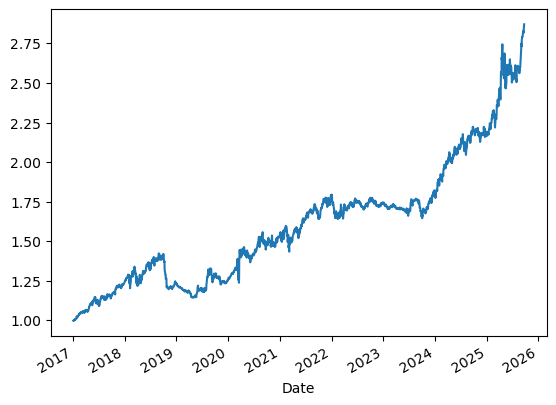

In [44]:
X = sm.add_constant(data['SPY'])
y = data['Strategy']
model = sm.OLS(y, X).fit()
print(model.summary())


alpha_daily = model.params['const']
alpha_annual = alpha_daily * 252
beta = model.params['SPY']
print("Annualized Alpha:", alpha_annual)
print("Beta:", beta)


resid = y - model.predict(X)
alpha_series = alpha_daily + resid
(alpha_series + 1).cumprod().plot()

Net Profit: 2.974015654119825
Gross Profit: 6.7802211071687815
Gross Loss: 5.319087104654649
Max Drawdown: -0.1923726699933178
Max Drawdown Duration (days): 488
Annualized Volatility: 0.1364296899243756


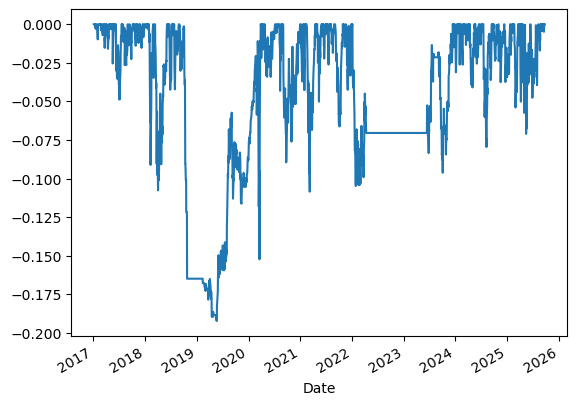

In [41]:
cumulative_value = (1 + strat_ret).cumprod()
net_profit = cumulative_value.iloc[-1] - 1
print("Net Profit:", net_profit)


gross_profit = strat_ret[strat_ret > 0].sum()
gross_loss = -strat_ret[strat_ret < 0].sum()
print("Gross Profit:", gross_profit)
print("Gross Loss:", gross_loss)


drawdown = cumulative_value / cumulative_value.cummax() - 1
max_drawdown = drawdown.min()
drawdown_duration = (drawdown < 0).astype(int).groupby((drawdown >= 0).astype(int).cumsum()).sum()
max_duration = drawdown_duration.max()
print("Max Drawdown:", max_drawdown)
print("Max Drawdown Duration (days):", max_duration)
drawdown.plot()


vol_daily = strat_ret.std()
vol_annual = vol_daily * np.sqrt(252)
print("Annualized Volatility:", vol_annual)
